In [ ]:
import os
from tqdm import tqdm
import fnmatch
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import numpy as np
import rasterio
from rasterio.merge import merge
from shapely.geometry import box
from shapely.errors import TopologicalError
import fnmatch
import torch
from utils import *
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
import re


import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.optim import lr_scheduler
from einops import rearrange

import functools
import models
from models.help_funcs import Transformer, TransformerDecoder, TwoLayerConv2d

from models.BIT import *

%matplotlib inline

In [2]:
model = define_G(net_G='base_transformer_pos_s4_dd8', input_nc=3)

initialize network with normal


In [3]:
# model

In [4]:
areas = ['larissa']
all_years = [2021]
# min_dates_gap = 30
# min_dates_gap = 0 
min_dates_gap = 1

temp_index = {}
temp_dates = {}

for area in areas:

    temp_index[area] = {}
    temp_dates[area] = {}
    
    df = pd.read_csv('data/output_tiles_{}/dates.csv'.format(area))
    df['date'] = pd.to_datetime(df['date'])
    
    
    # Extract year and create an incremental counter for each year
    df["year"] = df["date"].dt.year
    df["yearly_counter"] = df.groupby("year").cumcount()
    
    dates = df['date'].values
    print(len(dates))
    filtered_dates = [dates[0]]
    
    # Iterate through the dates and keep only those at least 5 days apart
    for date in dates[1:]:
        if date - filtered_dates[-1] >= np.timedelta64(min_dates_gap, 'D'):
            filtered_dates.append(date)
    
    dates = np.array(filtered_dates)
    print(len(dates))
    
    df = df[df['date'].isin(dates)]
    
    for year in all_years:
        temp_index[area][year] = df[df['year']==year]['yearly_counter'].values
        temp_dates[area][year] = df[df['year']==year]['date'].values

76
76


In [5]:
all_tiles = {}

for area in areas:
    
    directory = 'data/output_tiles_{0}/{1}/'.format(area, all_years[0])
    pattern = 'tile_*_dt_0.tif'
    matching_files = sorted([f for f in os.listdir(directory) if fnmatch.fnmatch(f, pattern)])
    all_tiles[area] = sorted([int(t.split('_')[1]) for t in matching_files])
    print(len(all_tiles[area]))
    # train_cases, test_cases = train_test_split(all_tiles[area], test_size=0.2, random_state=42)
    # train_cases, test_cases = train_test_split(all_tiles[area], test_size=0.001, random_state=42)

1


In [6]:
all_tiles[area]

[0]

In [13]:
ndvi_thresh = 0.5
ndvi_diff_thresh = -0.1
bsi_thresh = -0.25
bsi_diff_thresh = 0.1
cloud_threshold = 10
cases_threshold = 0.0
area_threshold = 0.0
step = 1

data_info = []
for area in areas:
    for year in tqdm(all_years):
        directory = 'data/output_tiles_{0}/{1}/'.format(area, year)
        for tile in all_tiles[area]:
            pattern = 'tile_{0}_dt_*.tif'.format(tile)
            matching_files = sorted([f for f in os.listdir(directory) if fnmatch.fnmatch(f, pattern)])
            all_cases = [directory + m for m in matching_files]
            all_cases = np.array(sorted(all_cases, key=lambda x: int(re.search(r"_dt_(\d+)\.tif", x).group(1))))
            all_cases = all_cases[temp_index[area][year]]
            cloudfree_cases = np.where(check_cloud_cases(all_cases, cloud_threshold))[0]
            dates_tile = temp_dates[area][year][cloudfree_cases]
            field_mask_file = "data/output_tiles_{0}/{1}/tile_{2}_mask_parcel_id.tif".format(area, year, tile)
            crop_mask_file = "data/output_tiles_{0}/{1}/tile_{2}_mask_crop_id.tif".format(area, year, tile)
            r = rasterio.open(field_mask_file).read(1)
            # if (r>0).sum()/r.size <= cases_threshold:
            #     continue
            for case in range(0, len(cloudfree_cases) - step, step):
                image_files = [all_cases[cloudfree_cases[case]],all_cases[cloudfree_cases[case+step]]]
                image_dates = [np.datetime_as_string(dates_tile[case], unit='D'),np.datetime_as_string(dates_tile[case+step], unit='D')]
                _, _, _, _, _, _, _, _, _, _, result = process_all_images(image_files, field_mask_file, crop_mask_file, ndvi_thresh, ndvi_diff_thresh, bsi_thresh, bsi_diff_thresh)
                if result.sum()/result.size >= area_threshold:
                    data_info.append((image_files, field_mask_file, crop_mask_file, image_dates))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.54s/it]


In [15]:
print(len(data_info))
# print(len(test_data_info))

24


In [30]:
ndvi_threshold = 0.5
ndvi_diff_threshold = -0.1
bsi_threshold = -0.25
bsi_diff_threshold = 0.1
batch_size = 16


# transform = CustomTransform(flip_horizontal=True, flip_vertical=True, angles=(-90, 90), gaussian_blur=True, color_jitter=True)

# dataset = ChangeDetectionDataset(data_info, ndvi_threshold, ndvi_diff_threshold, bsi_threshold, bsi_diff_threshold, transform=transform)
dataset = ChangeDetectionDataset(data_info, ndvi_threshold, ndvi_diff_threshold, bsi_threshold, bsi_diff_threshold)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# dataset_test = ChangeDetectionDataset(test_data_info, ndvi_threshold, ndvi_diff_threshold, bsi_threshold, bsi_diff_threshold)
# dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Example usage of dataloader
for pre_image, post_image, label, mask_path, crop_path, image_dates in dataloader:
    print(pre_image.shape, post_image.shape, label.shape)
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [31]:
len(dataloader)

2

In [32]:
# model = torch.load("models_checkpoints/BIT.pth", weights_only=False)
model = torch.load("models_checkpoints/BIT_final_refined.pth", weights_only=False, map_location=torch.device('cpu'))

In [33]:
# # Train the model
# num_epochs = 20
# train_model(model, dataset, dataset_test, num_epochs, device='cuda', lr=0.001)

In [34]:
# torch.save(model, "models_checkpoints/BIT_final_refined.pth")

In [35]:
# def forward_pass(model, pre_image, post_image):
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         output = model(pre_image.unsqueeze(0), post_image.unsqueeze(0))  # Unsqueeze adds batch dimension
#         prediction = torch.argmax(output[0], dim=1)  # Get the predicted label
#     return prediction

In [36]:
pre_image.shape

torch.Size([16, 3, 256, 256])

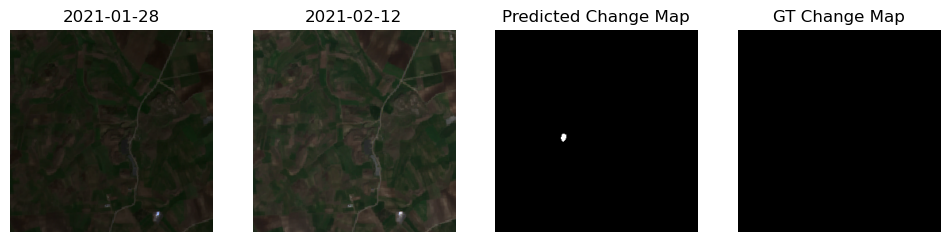

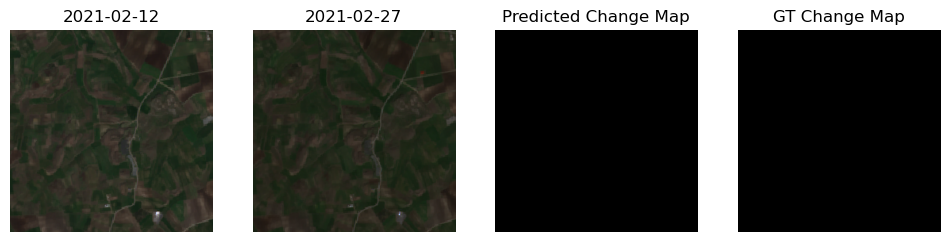

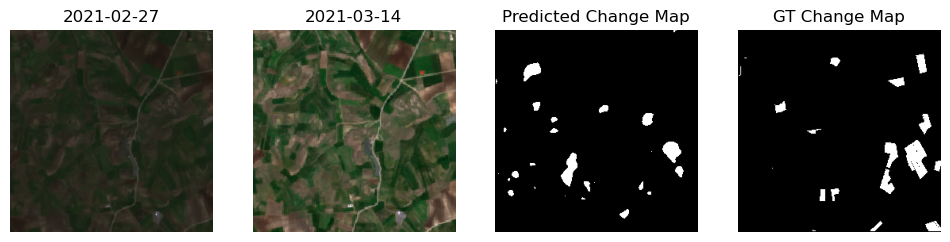

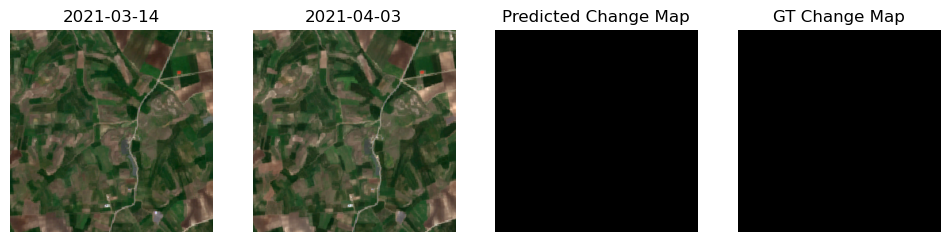

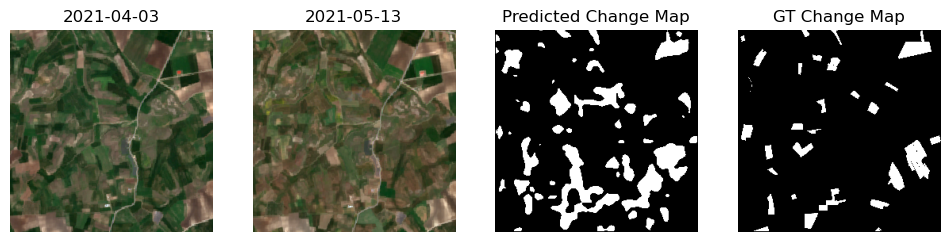

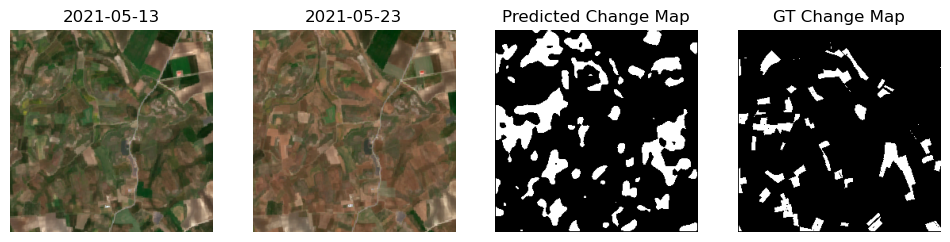

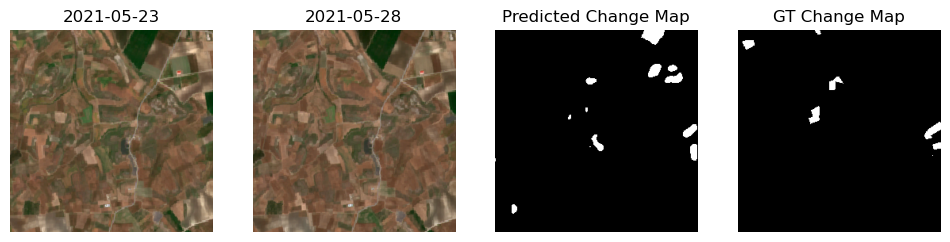

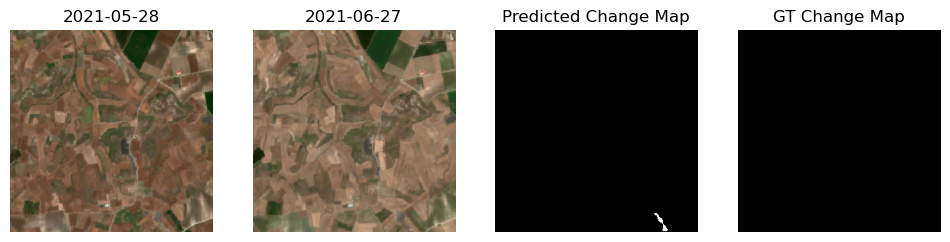

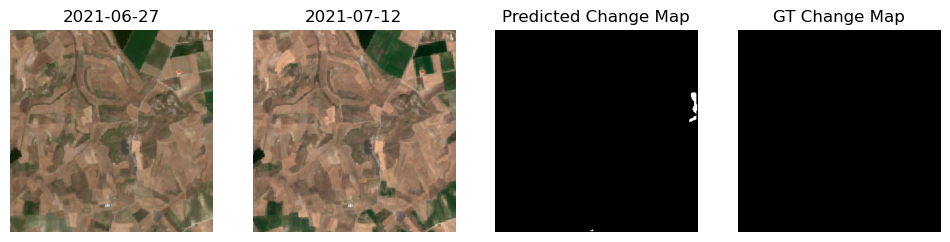

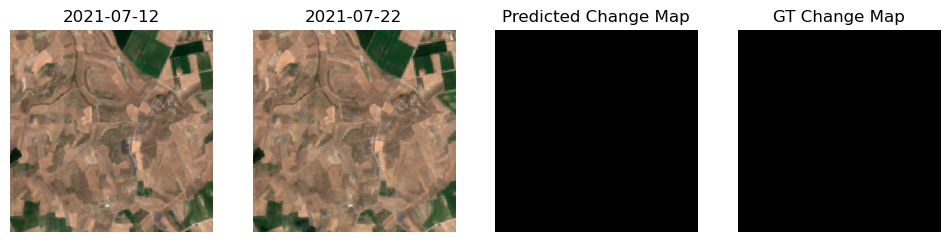

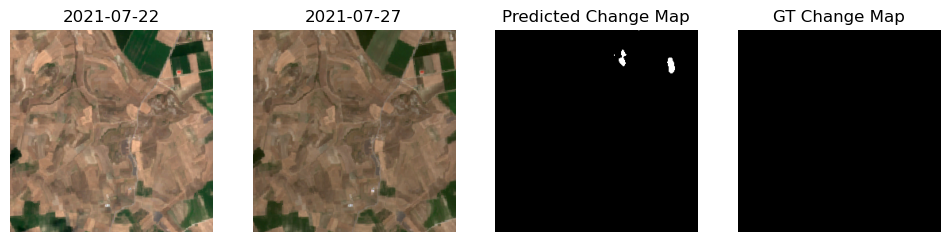

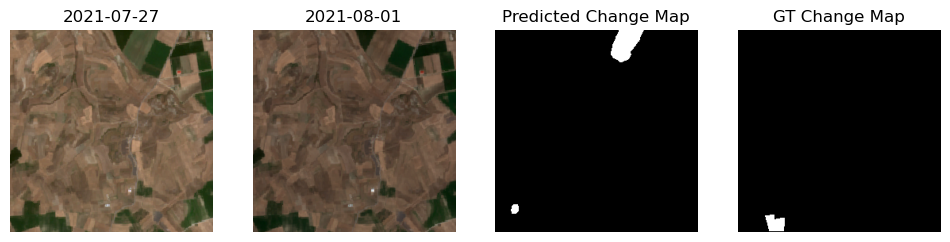

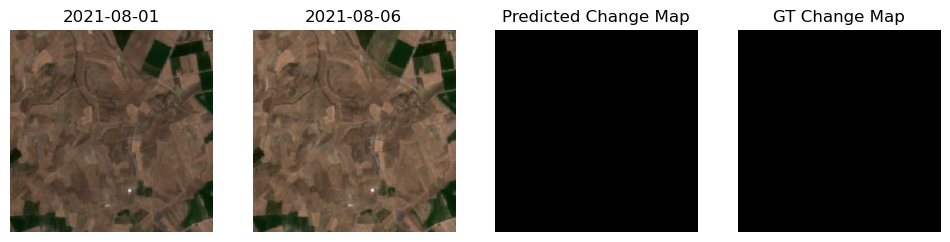

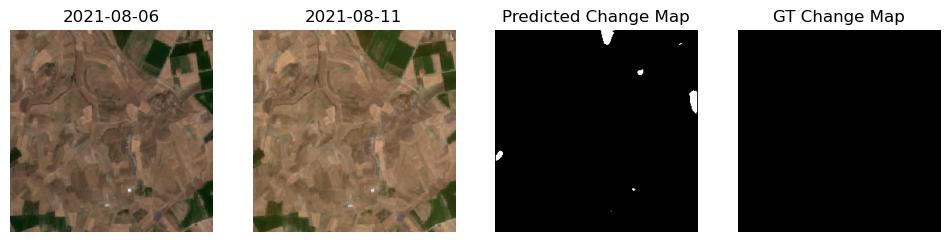

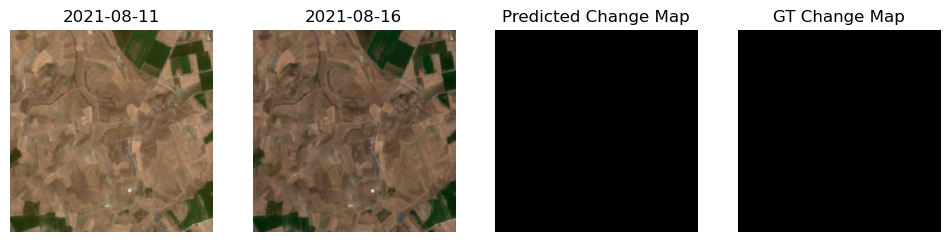

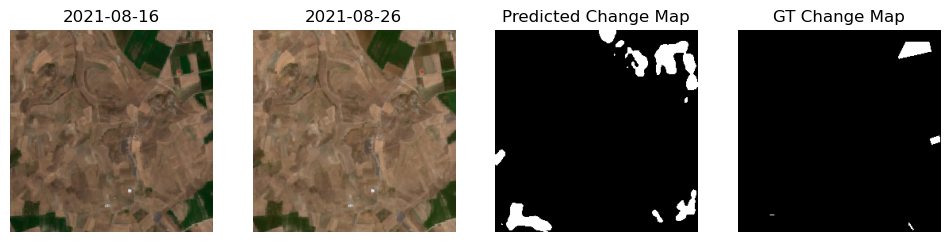

In [38]:
device = 'cpu'
model.eval()
n = 0 


for pre_image, post_image, target, mask_path, crop_path, image_dates in dataloader:
    if n!= 0:
        n += 1
        continue
    pre_image, post_image, target = pre_image.to(device), post_image.to(device), target.to(device)
    with torch.no_grad():
        output = model(pre_image, post_image)
    for case in range(batch_size):
        prediction = torch.argmax(output, dim=1)[case].cpu().numpy()  # Move to CPU for NumPy
        target_i = target[case].cpu().numpy()
        pre_image_i = pre_image[case].permute(1, 2, 0).cpu().numpy()  # Move to CPU for NumPy
        post_image_i = post_image[case].permute(1, 2, 0).cpu().numpy()
        pre_date = image_dates[0][case]
        post_date = image_dates[1][case]
        
        # Plot the images and prediction
        plt.figure(figsize=(12, 4))
        
        # Pre-change image
        plt.subplot(1, 4, 1)
        plt.imshow(scale_rgb_image(pre_image_i[:,:,:]*15000))
        plt.title(pre_date)
        plt.axis('off')
        
        # Post-change image
        plt.subplot(1, 4, 2)
        plt.imshow(scale_rgb_image(post_image_i[:,:,:]*15000))
        plt.title(post_date)
        plt.axis('off')
        
        # Prediction (change/no change)
        plt.subplot(1, 4, 3)
        plt.imshow(prediction, cmap='gray')  # Assuming binary change detection
        plt.title('Predicted Change Map')
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.imshow(target_i, cmap='gray')  # Assuming binary change detection
        plt.title('GT Change Map')
        plt.axis('off')
        
        plt.show()

    n += 1
    # if n > len(dataloader_test):
    # if n > 5:
    break